In [1]:
# Use anydoor Lda
import torch
torch.set_num_threads(2)
import sys
from omegaconf import OmegaConf

sys.path.append("./AnyDoor/")
from ldm.util import instantiate_from_config

conf = OmegaConf.load("src/anydoor_original/configs/anydoor.yaml")

anydoor_lda = instantiate_from_config(conf.model.params.first_stage_config)
anydoor_lda.load_state_dict(torch.load("ckpt/original_lda_anydoor.ckpt", weights_only=True, map_location="cpu"))

making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...


<All keys matched successfully>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16
anydoor_lda.to(device, dtype=dtype)
True

True

In [3]:
tensor = torch.load("result_x.pt", weights_only=True).to(device)
tensor.shape

torch.Size([1, 4, 64, 64])

In [4]:
with torch.no_grad():
    z = 1. / 0.18215 * tensor
    final = anydoor_lda.decode(z)

In [5]:
final_bis = final.to("cpu", torch.float32)

In [6]:
import einops
import numpy as np

x_samples = (einops.rearrange(final_bis, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy()#.clip(0, 255).astype(np.uint8)

pred = x_samples[0]
pred = np.clip(pred,0,255)[1:,:,:]
sizes = np.array([512, 512, 512, 512])
tar_box_yyxx_crop = np.array([ 0,512,0,512])


In [7]:
import cv2
import numpy as np

background_image_path = 'examples/background.png'
background_mask_path = 'examples/background_mask.png'
object_image_path = 'examples/object.png'


# background image
back_image = cv2.imread(background_image_path).astype(np.uint8)
back_image = cv2.cvtColor(back_image, cv2.COLOR_BGR2RGB)


In [8]:
def crop_back( pred, tar_image,  extra_sizes, tar_box_yyxx_crop):
    H1, W1, H2, W2 = extra_sizes
    y1,y2,x1,x2 = tar_box_yyxx_crop    
    pred = cv2.resize(pred, (W2, H2))
    m = 5 # maigin_pixel

    if W1 == H1:
        tar_image[y1+m :y2-m, x1+m:x2-m, :] =  pred[m:-m, m:-m]
        return tar_image

    if W1 < W2:
        pad1 = int((W2 - W1) / 2)
        pad2 = W2 - W1 - pad1
        pred = pred[:,pad1: -pad2, :]
    else:
        pad1 = int((H2 - H1) / 2)
        pad2 = H2 - H1 - pad1
        pred = pred[pad1: -pad2, :, :]

    gen_image = tar_image.copy()
    gen_image[y1+m :y2-m, x1+m:x2-m, :] =  pred[m:-m, m:-m]
    return gen_image

In [9]:
gen_image = crop_back(pred, back_image, sizes, tar_box_yyxx_crop) 

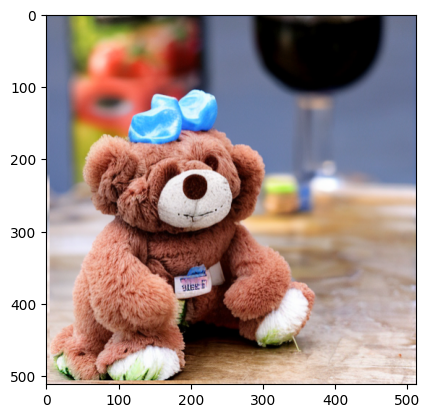

In [ ]:
# Display the image
import matplotlib.pyplot as plt
plt.imshow(gen_image)



In [11]:
# Save the image
cv2.imwrite('examples/gen_image_anydoor_lda.png', cv2.cvtColor(gen_image, cv2.COLOR_RGB2BGR))

True